# Self driving car nanodegree
## Project 1: Finding lane lines

This is the first project of the Udacity's nanodegree in autonomous vehicles. In this project concepts of computer vision are used in order to detect lines on the street through a camera. For that the library OpenCV is used.


### Import packages
First we will be importing the relevant packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

### Read images from the file system

In this project we work first with four images, applying the code on them before doing it on a video. Here we read the images from the project folder

In [2]:
# Read image 1 with solid white line at the right and dashed white line at the left
imgWhite1 = mpimg.imread("test_images/solidWhiteCurve.jpg")

# Read image 2 with solid white line at the right and dashed white line at the left
imgWhite2 = mpimg.imread("test_images/solidWhiteRight.jpg")

# Read image 1 with solid yellow line at the left and dashed white line at the right
imgWhYellow1 = mpimg.imread("test_images/solidYellowCurve.jpg")

# Read image 2 with solid yellow line at the left and dashed white line at the right
imgWhYellow2 = mpimg.imread("test_images/solidYellowCurve2.jpg")

### Print imported images

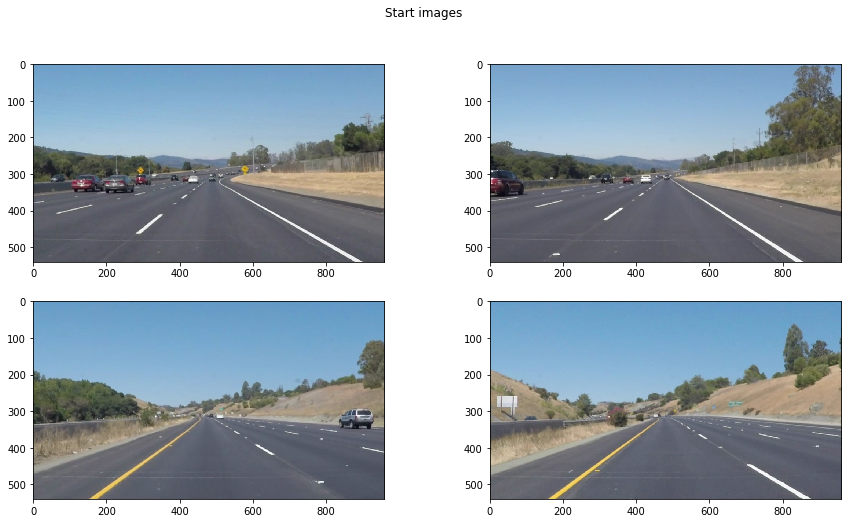

In [3]:
# We plot the four images as a subplot
fig, axs = plt.subplots(2,2)
fig.suptitle("Start images")
fig.set_figheight(8)
fig.set_figwidth(15)

images = []

images.append(axs[0,0].imshow(imgWhite1))
images.append(axs[0,1].imshow(imgWhite2))
images.append(axs[1,0].imshow(imgWhYellow1))
images.append(axs[1,1].imshow(imgWhYellow2))


### Processing one image step by step

First the image is converted into gray scale using the OpenCV function cvtColor. Here it is important to mention that the image will not look like grayscale if we only print it like imshow(image). It has to be printed like imshow(image, cmap='gray'). That also counts for the gaussian blurring and the canny's boundaries detection algorithm. 

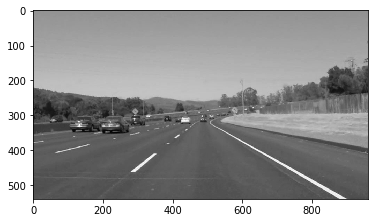

In [4]:
# We use the function cvtColor from OpenCV to convert the image into a gray scale image
imgWhite1_gray = cv2.cvtColor(imgWhite1, cv2.COLOR_RGB2GRAY)
plt.imshow(imgWhite1_gray, cmap='gray')

Now the gaussian filter is used to make the image blurry, eliminating some boundaries 

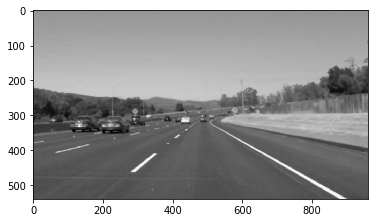

In [5]:
Gaussian_kernelSize = 5
imgWhite1_Gaussian = cv2.GaussianBlur(imgWhite1_gray, (Gaussian_kernelSize, Gaussian_kernelSize), 0)
plt.imshow(imgWhite1_Gaussian, cmap='gray')

Now the Canny's algorithm is executed to detect the edges in the image

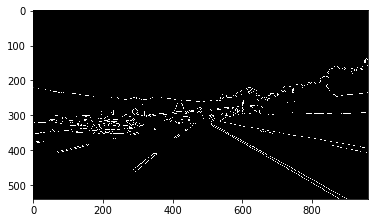

In [6]:
low_threshold = 50
high_threshold = 150
imgWhite1_edges = cv2.Canny(imgWhite1_Gaussian, low_threshold, high_threshold)
plt.imshow(imgWhite1_edges, cmap='gray')

On the other side, a poligon of the generated edges image is defined to apply inside of it the Hough's transformation. For that the OpenCV functions "fillPoly" and "bitwise_and" are used 

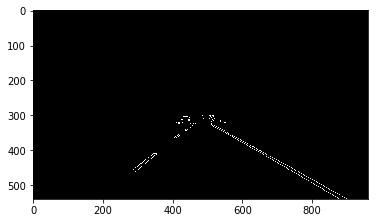

In [7]:
# An empty image with the same dimensions than the image of the edges is created to draw inside it
imgWhite1_edges_mask = np.zeros_like(imgWhite1_edges)
ignore_mask_color = 255
# The vertices of a mask polygon are defined. This polygon is used to select a region of the picture where we want 
# to find the lane lines.
Hough_area_vertices = np.array ([[(150, imgWhite1_edges.shape[0]),(430, 300),(520,300),(900, imgWhite1_edges.shape[0])]],
                                dtype = np.int32)
# The variable imgWhite1_edges_mask is filled with white in the area defined by the polygon with the vertices defined
# above
cv2.fillPoly(imgWhite1_edges_mask, Hough_area_vertices, ignore_mask_color)
# bitwise_and is used here in order to get the intersection of pixels between the mask and the edges image
imgWhite1_edges_masked = cv2.bitwise_and(imgWhite1_edges, imgWhite1_edges_mask)
# Finally the masked image is printed, showing only the edges inside the polygon and the rest black
plt.imshow(imgWhite1_edges_masked, cmap='gray')

Now the Hough transformation is used to detect lines inside the poligon

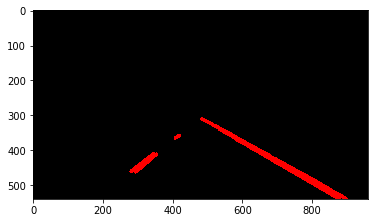

In [8]:
# An empty image with the same dimensions than the original image is created to draw inside it
imgWhite1_lines = np.zeros_like(imgWhite1)
Ho_rho = 1  # Distance resolution in pixels of the Hough grid (default 1 pixel)
Ho_theta = 2*np.pi/180 # Angular resolution in radians of the Hough grid (default 1 degree)
Ho_threshold = 50 # Minimum number of intersections needed in order to determine that a point in the Hough space is 
                  # a line (default 15)
Ho_min_line_length = 10 # Minimum number of pixels making a line (default 10 px)
Ho_max_line_gap = 10 # Maximum gap of pixels between line segments (default 10 px)

# The Hough transformation is executed, getting an array of endpoints of the lines detected
imgWhite1_points_def_lines = cv2.HoughLinesP(imgWhite1_edges_masked, Ho_rho, Ho_theta, 
                                          Ho_threshold, np.array([]), Ho_min_line_length, Ho_max_line_gap)

# Now the lines are drawn into a blank image using the points detected
for drawing_line in imgWhite1_points_def_lines:
    for x1, y1, x2, y2 in drawing_line:
        cv2.line(imgWhite1_lines, (x1,y1),(x2,y2),(255,0,0),10)
        
plt.imshow(imgWhite1_lines)

Now the lines image and the original image are put together

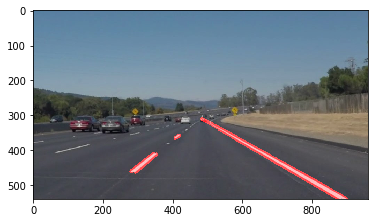

In [9]:
imgWhite1_output = cv2.addWeighted(imgWhite1, 0.8, imgWhite1_lines, 1, 0)
plt.imshow(imgWhite1_output)

The image received as output shows the lane lines, but they are interrupted when a line is dashed. We want to have the entire line drawn, without interrupts when it is dashed.

In order to do that, the position at the beginning and at the end of the lines are calculated using the points resulting from the Hough transformation.

The points resulting from the Hough transformation are separated in two groups, one for the right line and another one for the left line. To do that, two empty lists are created and with the slope value it is decided if they are part of the right line or of the left line.

Then, these lists are iterated separately and for every point the x values corresponding to the bottom of the image and to the far horizon of the lanes are calculated and appended to two empty lists corresponding to the two X coordinate values.

Then the average between all the calculated values corresponding to the two X coordinate values is calculated and with the two points a line is created into a blank image.

Finally, the image is printed to see if the result is correct.

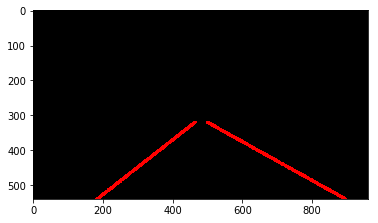

In [10]:
# Create two lists of points, one for the left line and another of the right line
imgWhite1_points_def_lines_right = []
imgWhite1_points_def_lines_left = []

for drawing_line in imgWhite1_points_def_lines:
    x1 = drawing_line[0,0]
    y1 = drawing_line[0,1]
    x2 = drawing_line[0,2]
    y2 = drawing_line[0,3]
    m = (y2 - y1)/(x2 - x1)
    
    if m > 0:
       imgWhite1_points_def_lines_right.append(drawing_line)
    else:
       imgWhite1_points_def_lines_left.append(drawing_line)

# Create four lists, where the calculated X coordinates are saved 
lower_x_values_right = []
upper_x_values_right = []
lower_x_values_left = []
upper_x_values_left = []

y_max = imgWhite1.shape[0] # Corresponds to the Y coordinate value at the bottom of the image
y_min = 320 # Corresponds to the Y coordinate value at the far horizon of the image, 
            # where the lines cannot be seen anymore
for drawing_line_right in imgWhite1_points_def_lines_right:
    m = (drawing_line_right[0,3] - drawing_line_right[0,1]) / (drawing_line_right[0,2] - drawing_line_right[0,0])
    x1 = drawing_line_right[0,0]
    y1 = drawing_line_right[0,1]
    lower_x_values_right.append((y_max - y1)/m + x1) # The lower X values are appended in the list
    upper_x_values_right.append((y_min - y1)/m + x1) # The upper X values are appended in the list
    
for drawing_line_left in imgWhite1_points_def_lines_left:
    m = (drawing_line_left[0,3] - drawing_line_left[0,1]) / (drawing_line_left[0,2] - drawing_line_left[0,0])
    x1 = drawing_line_left[0,0]
    y1 = drawing_line_left[0,1]
    lower_x_values_left.append((y_max - y1)/m + x1) # The lower X values are appended in the list
    upper_x_values_left.append((y_min - y1)/m + x1) # The upper X values are appended in the list  
    
avg_lower_x_right = int(np.mean(lower_x_values_right)) # The mean for the low X value of the right line is calculated
avg_upper_x_right = int(np.mean(upper_x_values_right)) # The mean for the high X value of the right line is calculated
avg_lower_x_left = int(np.mean(lower_x_values_left)) # The mean for the low X value of the left line is calculated
avg_upper_x_left = int(np.mean(upper_x_values_left)) # The mean for the high X value of the left line is calculated

# An empty image with the same dimensions than the original image is created to draw inside it
imgWhite1_lines_2 = np.zeros_like(imgWhite1)

# The right line is drawn using the average values
cv2.line(imgWhite1_lines_2, (avg_lower_x_right, y_max), (avg_upper_x_right, y_min), (255,0,0),10)
# The left line is drawn using the average values
cv2.line(imgWhite1_lines_2, (avg_lower_x_left, y_max), (avg_upper_x_left, y_min), (255,0,0),10)

# The image including only the lines is printed
plt.imshow(imgWhite1_lines_2)
    

Now the image with the lines created before is overlaped into the original image

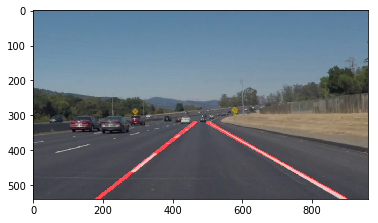

In [11]:
imgWhite1_output_2 = cv2.addWeighted(imgWhite1, 0.8, imgWhite1_lines_2, 1, 0)
plt.imshow(imgWhite1_output_2)

### Generalized functions for pipeline
Now a pipeline is created for all the other images. The functions are encapsulated in the file "Find_lane_lines.py". To use the functions contained in there the magic word run is used.

In [12]:
%run Find_lane_lines.py

Now the gray scale function is tried on the second image

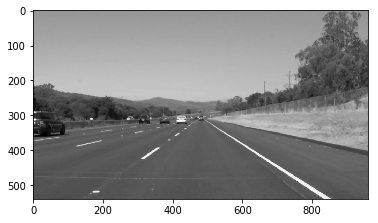

In [13]:
imgWhite2_gray = grayscale(imgWhite2)
plt.imshow(imgWhite2_gray, cmap='gray')

Now the gaussian blur and the canny

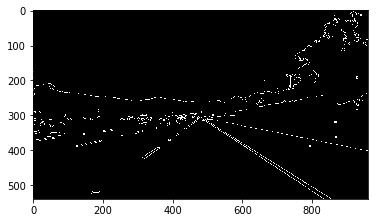

In [14]:
imgWhite2_Gaussian = gaussian_blur(imgWhite2_gray, 5)
imgWhite2_Edges = canny(imgWhite2_Gaussian, 50, 150)
plt.imshow(imgWhite2_Edges, cmap='gray')

Now the region of interest:

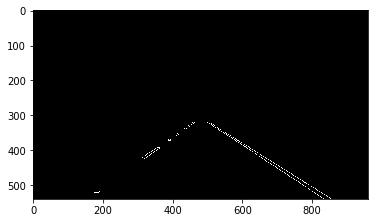

In [15]:
imgWhite2_Hough_vertices = houghVertices(150, 430, 900, 520, imgWhite2_Edges.shape[0], 320)
imgWhite2_Edges_masked = region_of_interest(imgWhite2_Edges, imgWhite2_Hough_vertices)
plt.imshow(imgWhite2_Edges_masked, cmap='gray')

Then the Hough transformation:

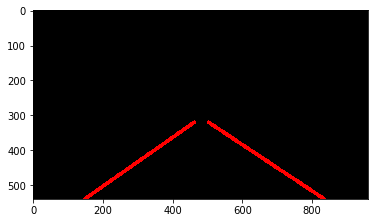

In [16]:
imgWhite2_lines = hough_lines(imgWhite2, imgWhite2_Edges_masked, 1, 2*np.pi/180, 50, 10, 10, 320)
plt.imshow(imgWhite2_lines)

And finally the lines are overlapped into the original image

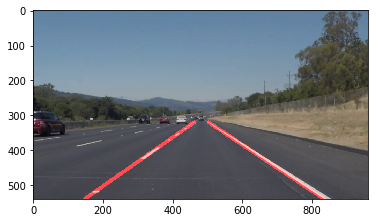

In [17]:
imgWhite2_output = weighted_img(imgWhite2, imgWhite2_lines)
plt.imshow(imgWhite2_output)

### Generalized pipeline function for any image
A generalized function for the pipeline called "findLines" was created and called with the other two images. This function will be used for the video.

First the function is tested with the image "imgWhYellow1":

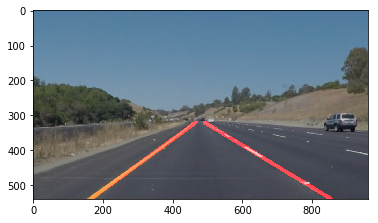

In [18]:
Canny_low_threshold = 50
lane_x_left_bottom = 150
lane_x_left_top = 430
lane_x_right_bottom = 900
lane_x_right_top = 520
lane_y_bottom = imgWhYellow1.shape[0]
lane_y_horizon = 320
Hough_rho = 1
Hough_theta = 2*np.pi/180
Hough_threshold = 50
Hough_min_line_len = 10
Hough_max_line_gap = 10

imgWhYellow1_output = findLanes(imgWhYellow1, Canny_low_threshold, lane_x_left_bottom, lane_x_left_top,
                               lane_x_right_bottom, lane_x_right_top, lane_y_bottom, lane_y_horizon, 
                               Hough_rho, Hough_theta, Hough_threshold, Hough_min_line_len, Hough_max_line_gap)

plt.imshow(imgWhYellow1_output)

Now with the image "imgWhYellow2":

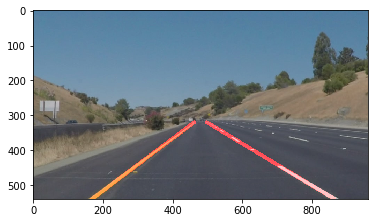

In [19]:
imgWhYellow2_output = findLanes(imgWhYellow2, Canny_low_threshold, lane_x_left_bottom, lane_x_left_top,
                               lane_x_right_bottom, lane_x_right_top, lane_y_bottom, lane_y_horizon, 
                               Hough_rho, Hough_theta, Hough_threshold, Hough_min_line_len, Hough_max_line_gap)
plt.imshow(imgWhYellow2_output)

It can be seen that the pipeline works very well with the four images. Now it is time to try it with videos. But first let's save the images into the directory "test_images_output".

In [20]:
plt.imsave("test_images_output/solidWhiteCurve_Output.jpg", imgWhite1_output_2, format = 'jpg')
plt.imsave("test_images_output/solidWhiteRight_Output.jpg", imgWhite2_output, format = 'jpg')
plt.imsave("test_images_output/solidYellowCurve_Output.jpg", imgWhYellow1_output, format = 'jpg')
plt.imsave("test_images_output/solidYellowCurve2_Output.jpg", imgWhYellow2_output, format = 'jpg')

### Processing video, part 1
Now that the pipeline is tested with four images, it is time to test it with a video. To do that, the following packages are imported:

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

And the function "process_image" is created. This function is needed by the moviepy function "fl_image":

In [22]:
def process_image(image):
    result = findLanes(image, Canny_low_threshold, lane_x_left_bottom, lane_x_left_top,
                               lane_x_right_bottom, lane_x_right_top, lane_y_bottom, lane_y_horizon, 
                               Hough_rho, Hough_theta, Hough_threshold, Hough_min_line_len, Hough_max_line_gap)

    return result

Now the video processing functions are used:

In [23]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|▏         | 3/221 [00:00<00:07, 28.75it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 2.65 s, sys: 95.5 ms, total: 2.74 s
Wall time: 3.48 s


And the video is ready:

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Processing video, part 2
Now lets try the same pipeline with the second video:

In [25]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 8.46 s, sys: 415 ms, total: 8.87 s
Wall time: 11.3 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

Until now it can be said that the pipeline works very well with the two given videos. Now let's try it with the challenge video.

### Challenge
Now lets try the pipeline with the challenge video:

In [27]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   0%|          | 0/251 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 5.44 s, sys: 304 ms, total: 5.74 s
Wall time: 10.1 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

The challenge video is not working. The lines are too long and are not accurate. So let's try doing the pipeline step by step to see where it fails. Let's do it with a frame of the video.

In [29]:
challenge_frame = clip3.get_frame(2)
clip3.save_frame('test_images/challenge_frame.jpg', t=2)

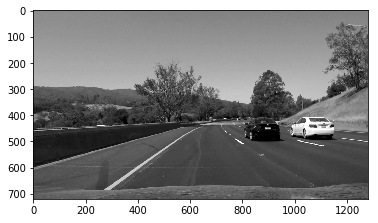

In [30]:
ch_frame_gray = grayscale(challenge_frame)
plt.imshow(ch_frame_gray, cmap='gray')

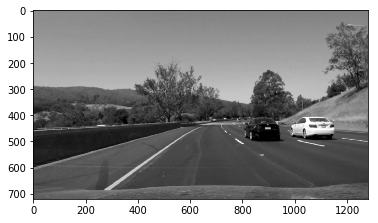

In [31]:
ch_frame_gaussian = gaussian_blur(ch_frame_gray, 5)
plt.imshow(ch_frame_gaussian, cmap='gray')

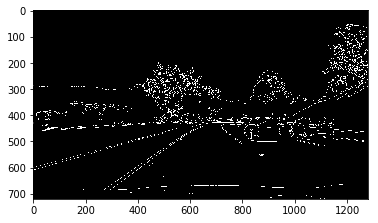

In [32]:
ch_frame_edges = canny(ch_frame_gaussian, Canny_low_threshold, 3*Canny_low_threshold)
plt.imshow(ch_frame_edges, cmap='gray')

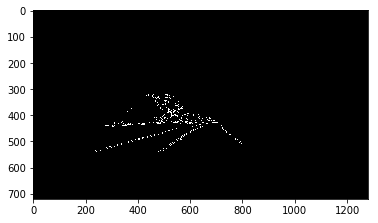

In [33]:
ch_frame_edges_Hough_vertices = houghVertices(lane_x_left_bottom, lane_x_left_top, lane_x_right_bottom, 
                                              lane_x_right_top, lane_y_bottom, lane_y_horizon)
ch_frame_edges_masked = region_of_interest(ch_frame_edges, ch_frame_edges_Hough_vertices)
plt.imshow(ch_frame_edges_masked, cmap='gray')

By executing the pipeline on this frame we can see two things. First, the image has another resolution, so the region of interest which is used to find the lines does not include enough information!. Additionally, the car can be seen in this image and the edges are recognized in the Canny transformation, so these edges may be building lines as well, which get mixed with the street lines. 

The problem should be solved by making the region of interest wider and lifting it a bit, so the car does not get recognized by the Hough transformation.

Now the function "houghVertices" was changed to take the parameter "lane_y_bottom" for the bottom of the region of interest instead of the bottom of the image, so the edges of the car can be ignored. The entire notebook was executed again to see if everything is still working for the other images and videos.

Now, the vertices of the region of interest need to be changed for the challenge video:

In [34]:
lane_x_left_bottom = 200
lane_x_left_top = 600
lane_x_right_bottom = 1000
lane_x_right_top = 800
lane_y_bottom = 650
lane_y_horizon = 450

With the parameters changed, the Canny masked image is created again:

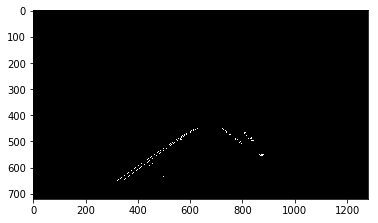

In [35]:
ch_frame_edges_Hough_vertices = houghVertices(lane_x_left_bottom, lane_x_left_top, lane_x_right_bottom, 
                                              lane_x_right_top, lane_y_bottom, lane_y_horizon)
ch_frame_edges_masked = region_of_interest(ch_frame_edges, ch_frame_edges_Hough_vertices)
plt.imshow(ch_frame_edges_masked, cmap='gray')

Now the masked canny image looks better. The next step is to detect and draw the lines:

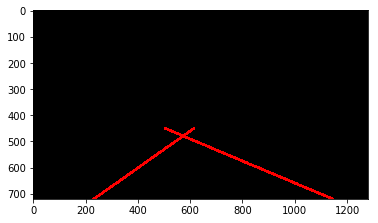

In [36]:
ch_frame_lines = hough_lines(challenge_frame, ch_frame_edges_masked, Hough_rho, Hough_theta, Hough_threshold,
                            Hough_min_line_len, Hough_max_line_gap, lane_y_horizon)
plt.imshow(ch_frame_lines)

Now the lines are also looking better, but not exactly where the original lines are, so the Hough and Canny parameters might need to be changed. But first, let's try the advance with the video to see how much it improved.

In [37]:
challenge_corrected_1_output = 'test_videos_output/challenge_corrected_1.mp4'
challenge_corrected_1_clip = clip3.fl_image(process_image)
%time challenge_corrected_1_clip.write_videofile(challenge_corrected_1_output, audio=False)

t:   3%|▎         | 8/251 [00:00<00:03, 77.25it/s, now=None]

Moviepy - Building video test_videos_output/challenge_corrected_1.mp4.
Moviepy - Writing video test_videos_output/challenge_corrected_1.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_corrected_1.mp4
CPU times: user 5.6 s, sys: 289 ms, total: 5.89 s
Wall time: 9.44 s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_corrected_1_output))

The video is looking surprisingly well, although the lines created with the pipeline of the last frame were wrong. The lines are not completely accurate though. So let's do some optimization on the Canny and Hough parameters.

In [40]:
challenge_frame_2 = clip3.get_frame(5)
clip3.save_frame('test_images/challenge_frame_2.jpg', t=5)

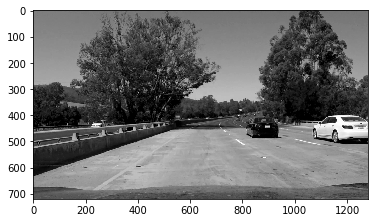

In [41]:
ch_frame_2_gray = grayscale(challenge_frame_2)
plt.imshow(ch_frame_2_gray, cmap='gray')

In this frame the lines are very difficult to recognize, even for a human. Let's do the pipeline further:

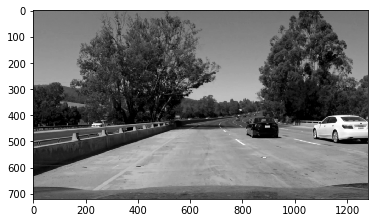

In [42]:
ch_frame_2_gaussian = gaussian_blur(ch_frame_2_gray, 5)
plt.imshow(ch_frame_2_gaussian, cmap='gray')

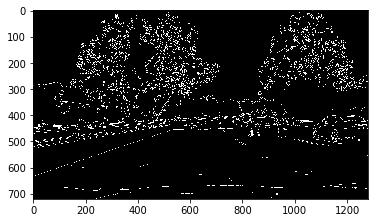

In [43]:
ch_frame_2_edges = canny(ch_frame_2_gaussian, Canny_low_threshold, 3*Canny_low_threshold)
plt.imshow(ch_frame_2_edges, cmap='gray')

It can be seen that the Canny don't recognize the line edges. Now it is time to adjust the "Canny_low_threshold":

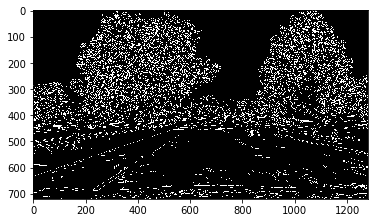

In [44]:
Canny_low_threshold = 20
ch_frame_2_edges = canny(ch_frame_2_gaussian, Canny_low_threshold, 3*Canny_low_threshold)
plt.imshow(ch_frame_2_edges, cmap='gray')

By changing "Canny_low_threshold" from 50 to 20, the edges of the lines are better recognized, but it also recognizes another details in the street, so the Hough parameter might need to be changed as well. First let's create the Hough lines with the current parameters:

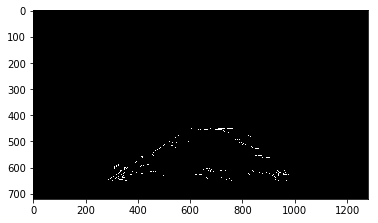

In [45]:
ch_frame_2_edges_Hough_vertices = houghVertices(lane_x_left_bottom, lane_x_left_top, lane_x_right_bottom, 
                                                lane_x_right_top, lane_y_bottom, lane_y_horizon)
ch_frame_2_edges_masked = region_of_interest(ch_frame_2_edges, ch_frame_2_edges_Hough_vertices)
plt.imshow(ch_frame_2_edges_masked, cmap='gray')

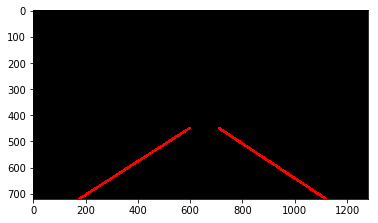

In [46]:
ch_frame_2_lines = hough_lines(challenge_frame_2, ch_frame_2_edges_masked, Hough_rho, Hough_theta, Hough_threshold,
                            Hough_min_line_len, Hough_max_line_gap, lane_y_horizon)
plt.imshow(ch_frame_2_lines)

The lines are looking good, but in the video bellow, they are still a bit unstable. Let's try changing the Hough parameters:

In [47]:
Hough_rho = 1
Hough_theta = 1*np.pi/180
Hough_threshold = 50
Hough_min_line_len = 40
Hough_max_line_gap = 2

With the parameters changed, let's plot the image again:

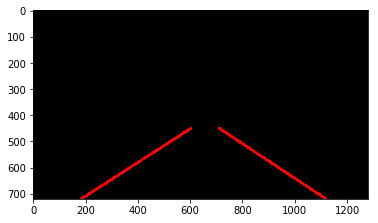

In [48]:
ch_frame_2_lines = hough_lines(challenge_frame_2, ch_frame_2_edges_masked, Hough_rho, Hough_theta, Hough_threshold,
                            Hough_min_line_len, Hough_max_line_gap, lane_y_horizon)
plt.imshow(ch_frame_2_lines)

Now let's try with the video again:

In [49]:
challenge_corrected_2_output = 'test_videos_output/challenge_corrected_2.mp4'
challenge_corrected_2_clip = clip3.fl_image(process_image)
%time challenge_corrected_2_clip.write_videofile(challenge_corrected_2_output, audio=False)

t:   3%|▎         | 8/251 [00:00<00:03, 69.09it/s, now=None]

Moviepy - Building video test_videos_output/challenge_corrected_2.mp4.
Moviepy - Writing video test_videos_output/challenge_corrected_2.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_corrected_2.mp4
CPU times: user 6.07 s, sys: 274 ms, total: 6.34 s
Wall time: 9.12 s


In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_corrected_2_output))

Now the lines are very stable and accurate, they do not jump to other positions like in the first try on the challenge video and they barely move out from the position of the actual lines. This is a very good result.